___
## Springboard Capstone 1: Liver Disease Prediction
### Logistic Model with Data Preprocessing and Dimensionality Reduction

Nils Madsen
___

### Overview of Rationale and Approach

The predictors in this problem are continuous, quantitative variables (with the exception of sex). As can be seen in the data storytelling, there is also some degree of covariance among different variables. In order to mitigate the effect of this covariance on the success of the logistic regression model, it would be best to reduce the dimensionality of this variable set while retaining most of the structure within the data.

Principal Component Analysis (PCA) is a common and effective tool for dimensionality reduction, and will return derived variables (components) that are uncorrelated. However, correct implementation of PCA requires that the data be unskewed, centered, and equally scaled between variables. Therefore, some data preprocessing steps are needed here.
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid')

In [2]:
# import cleaned data
liver_df = pd.read_csv('indian_liver_dataset_clean.csv', index_col=0)
print(liver_df.info())

# convert sex and disease group variables to numeric form
liver_df.sex = liver_df.sex.map({'Male': 1, 'Female': 0})
liver_df['liver disease'] = liver_df['liver disease'].astype('int')
liver_df.head(10)

# convert age, ALP, ALT, and AST to float64
liver_df.age = liver_df.age.astype(np.float64)
liver_df.ALP = liver_df.ALP.astype(np.float64)
liver_df.ALT = liver_df.ALT.astype(np.float64)
liver_df.AST = liver_df.AST.astype(np.float64)
print(liver_df.info())
liver_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
liver disease    583 non-null bool
dtypes: bool(1), float64(5), int64(4), object(1)
memory usage: 50.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null float64
sex              583 non-null int64
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null float64
ALT              583 non-null float64
AST              583 non-null float64
total protein    583 non-null float64
album

,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,liver disease
0,65.0,0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,1,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,1,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,1,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,1,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


___
### Skew correction
___

First, visualize and correct for skewed distributions by transforming each variable as needed.

In [3]:
def vis_transforms(df, variable, bins=20):
    ''' Visualize distribution after skew-correcting transforms, in order of increasing strength'''
    array = np.array(df[variable])
    
    # Untransformed
    plt.hist(array, bins=bins)
    plt.title('{} - Untransformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(array))
    
    # Square root
    plt.hist(np.sqrt(array), bins=bins)
    plt.title('{} - Square root transformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(np.sqrt(array)))
    
    # Log
    plt.hist(np.log(array), bins=bins)
    plt.title('{} - Log transformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(np.log(array)))
    
    # Box-Cox
    bc_transformed, bestlambda = stats.boxcox(array)
    plt.hist(bc_transformed, bins=bins)
    plt.title('{} - Box-Cox transformed (lambda = {})'.format(variable, round(bestlambda,2)))
    plt.show()
    print('Skew: ', stats.skew(bc_transformed))
    
    # Reciprocal
    plt.hist(np.reciprocal(array), bins=bins)
    plt.title('{} - reciprocal transformed'.format(variable))
    plt.margins(0.1)
    plt.show()
    print('Skew: ', stats.skew(np.reciprocal(array)))

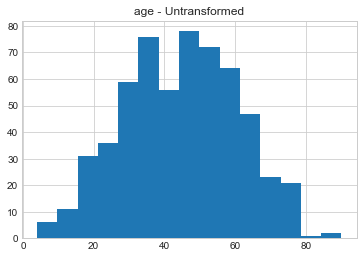

Skew:  -0.0293096531748283


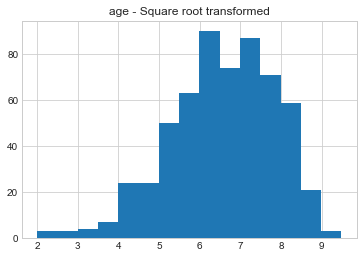

Skew:  -0.5567440839104613


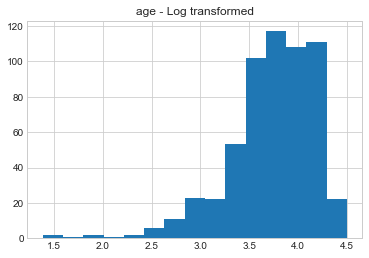

Skew:  -1.4110571310620537


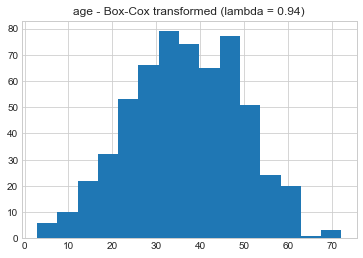

Skew:  -0.08281295966839941


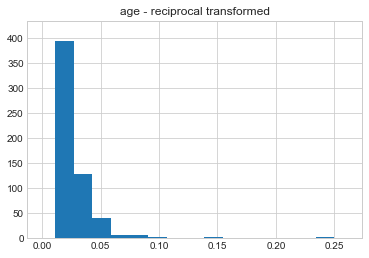

Skew:  5.978472158820993


In [4]:
# Age
vis_transforms(liver_df, 'age', bins=15)

Age is not skewed in this dataset.

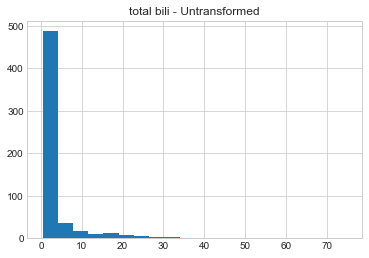

Skew:  4.8948385248878825


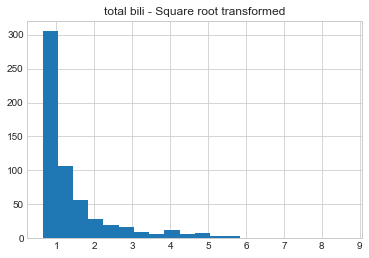

Skew:  2.4955274724497323


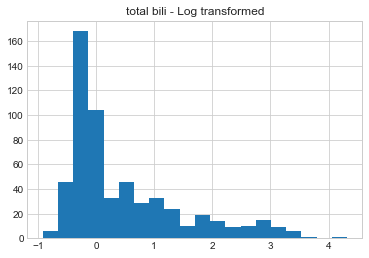

Skew:  1.315100356738154


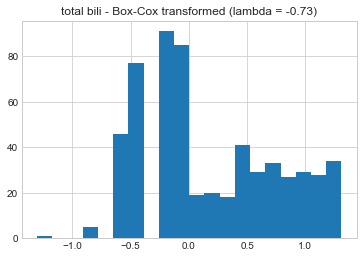

Skew:  0.3489293110399693


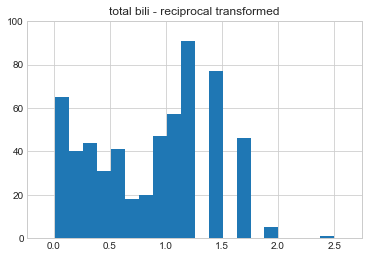

Skew:  -0.09568583556457612


In [5]:
# total bilirubin
vis_transforms(liver_df, 'total bili')

Total bilirubin is heavily skewed. Reciprocal transformation returns the best result.

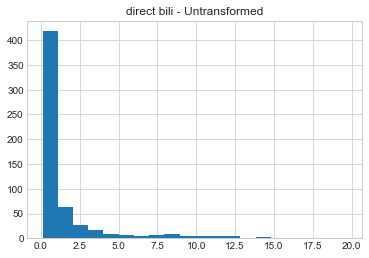

Skew:  3.2041317604378037


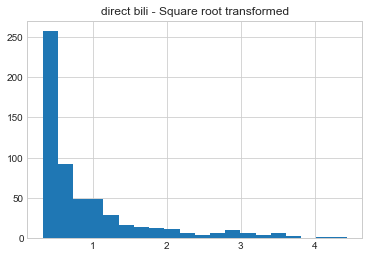

Skew:  1.9747951975374458


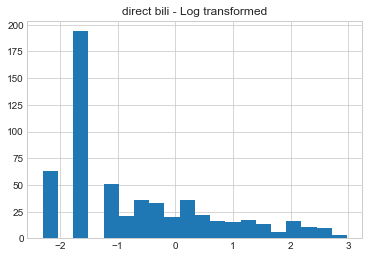

Skew:  0.82905027934287


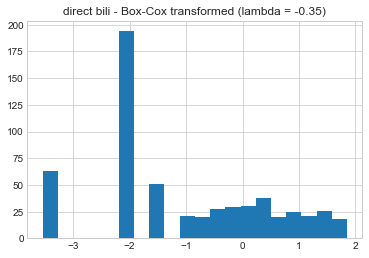

Skew:  0.1811891964664948


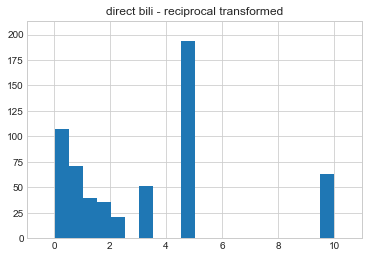

Skew:  0.8441135396281609


In [6]:
# direct bilirubin
vis_transforms(liver_df, 'direct bili')

Attempting to unskew direct bili with any transformation stronger than square root causes the distribution to be broken up into discrete values. This is due to inadequate precision at lower values of direct bili (usually only to the scale of 0.1). Box-Cox transformation is the best that can be done with this variable, but it also may be best not to use this variable in the model due to the inability to adequately correct for the skew.

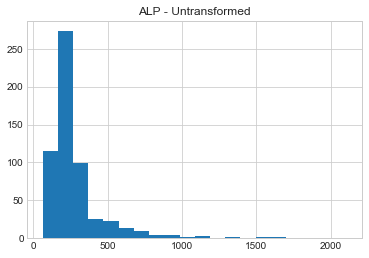

Skew:  3.755412227842381


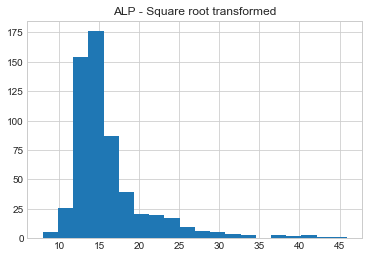

Skew:  2.4157909854044624


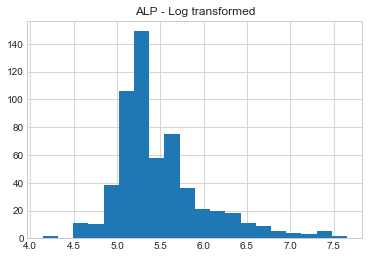

Skew:  1.3213570098333647


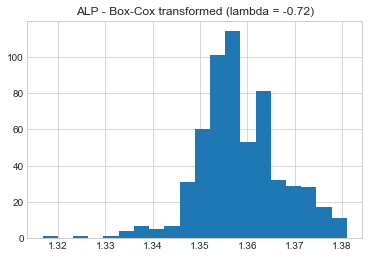

Skew:  -0.048538060779294435


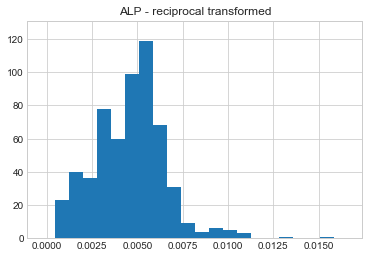

Skew:  0.6270021579464452


In [7]:
# ALP
vis_transforms(liver_df, 'ALP', bins=20)

ALP is also heavily skewed, but fortunately not to the same degree as the bilirubin measurements. Box-Cox transformation corrects best for the skew.

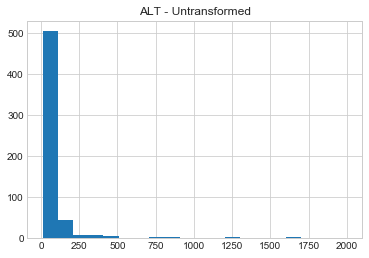

Skew:  6.532329464026143


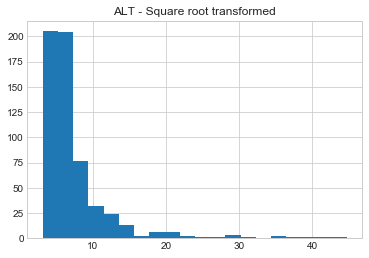

Skew:  3.7353834215580224


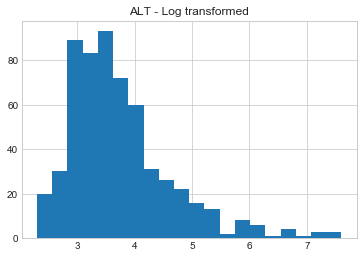

Skew:  1.421959661592674


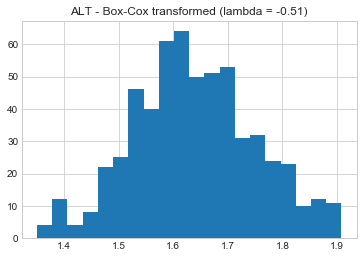

Skew:  0.07703671486028012


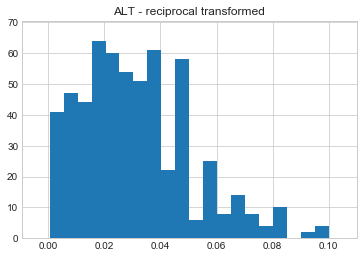

Skew:  0.7873264220205453


In [8]:
# ALT
vis_transforms(liver_df, 'ALT')

ALT is heavily skewed as well. Fortunately, Box-Cox is able to correct well for the skew.

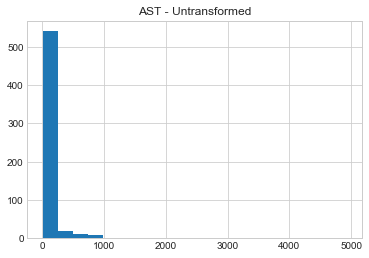

Skew:  10.519023554210735


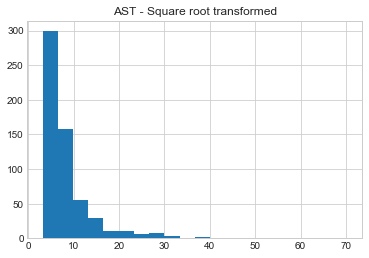

Skew:  3.9402977769451253


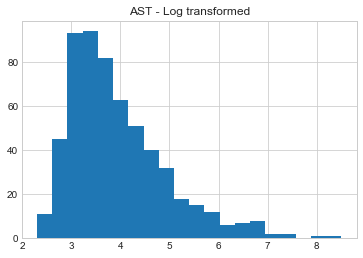

Skew:  1.1918217216071025


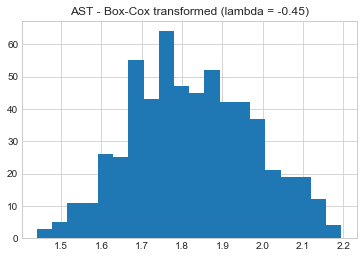

Skew:  0.10578146566817681


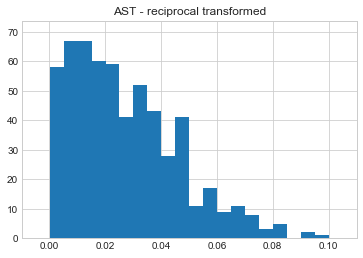

Skew:  0.8151972360517906


In [9]:
# AST
vis_transforms(liver_df, 'AST')

AST is the most skewed of all variables in the dataset, but Box-Cox is able to correct well for the skew.

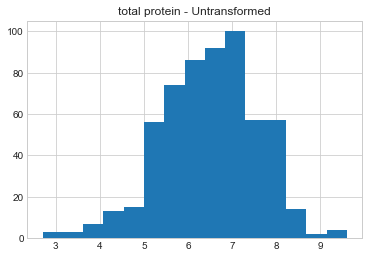

Skew:  -0.28493665487447245


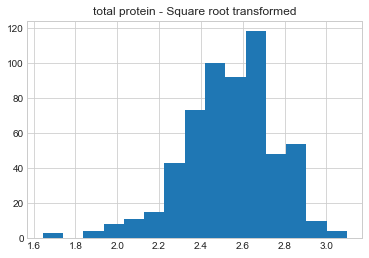

Skew:  -0.5985810227660848


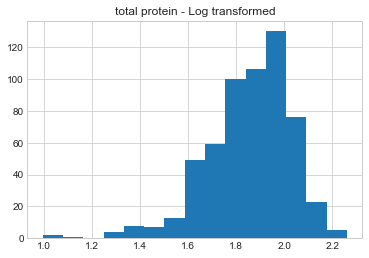

Skew:  -0.9714282276511963


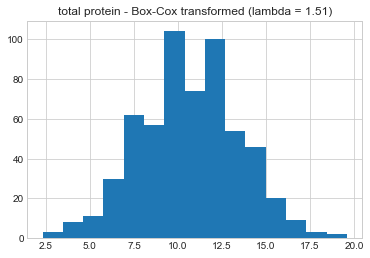

Skew:  -0.003159535900629572


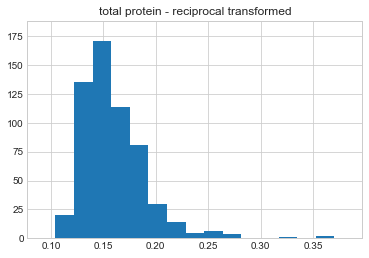

Skew:  2.0101848669830256


In [10]:
# total protein
vis_transforms(liver_df, 'total protein', bins=15)

Total Protein is only mildly skewed. Box-Cox is the best transformation here as well.

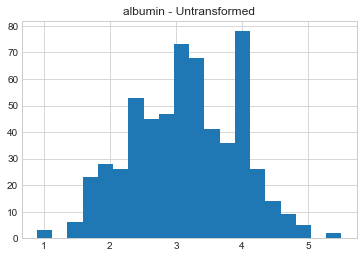

Skew:  -0.043572251735588034


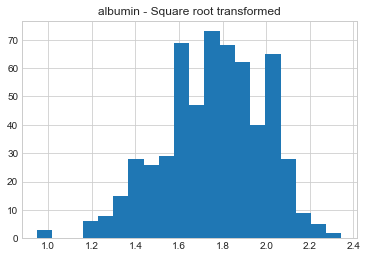

Skew:  -0.39228579120050283


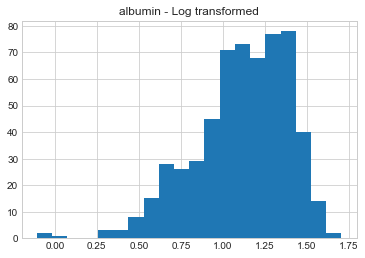

Skew:  -0.8216219398106923


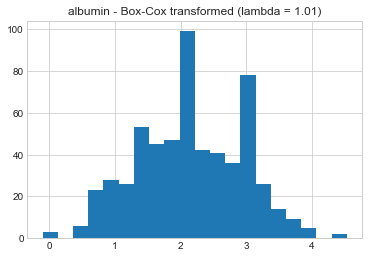

Skew:  -0.03930071321104507


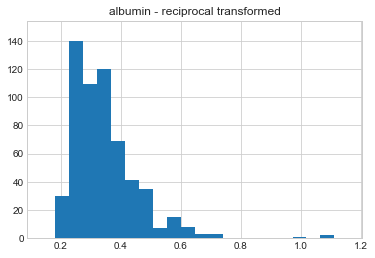

Skew:  2.2556968285583467


In [11]:
# albumin
vis_transforms(liver_df, 'albumin')

Albumin is not skewed in this dataset.

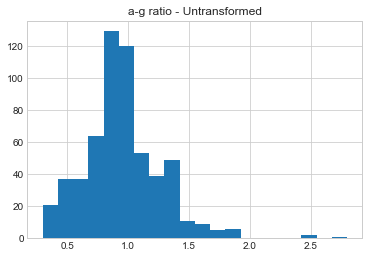

Skew:  0.9931397332044614


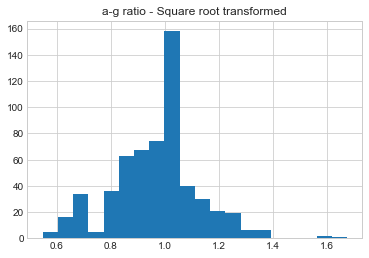

Skew:  0.22449902300681024


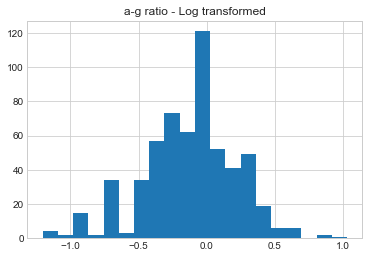

Skew:  -0.4212705135969138


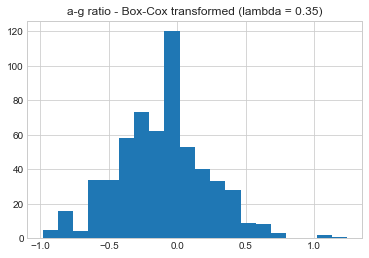

Skew:  0.020961981345698398


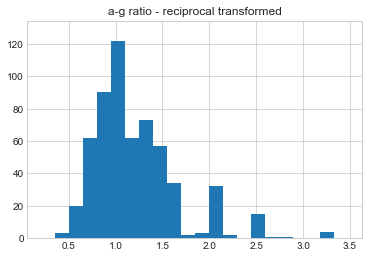

Skew:  1.6443228508676266


In [12]:
# a-g ratio
vis_transforms(liver_df, 'a-g ratio')

A-g ratio is slightly skewed in the data, and Box-Cox performs best to correct for this.

Box-Cox transform lambdas: 
 {'direct bili': -0.35003201468043943, 'ALP': -0.7212034865791301, 'ALT': -0.5135479524153377, 'AST': -0.4451636047263362, 'total protein': 1.5132400866083167, 'a-g ratio': 0.3491627844238581}


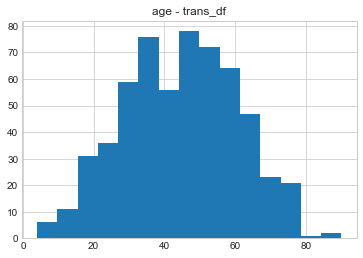

Skew:  -0.0293096531748283


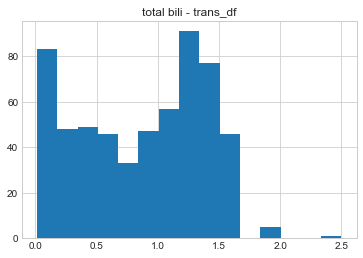

Skew:  -0.09568583556457612


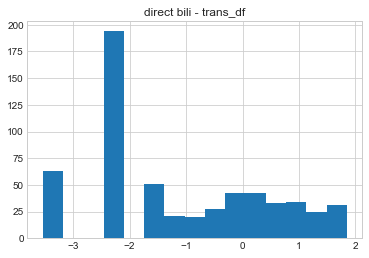

Skew:  0.1811891964664948


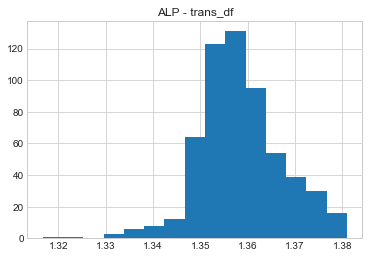

Skew:  -0.048538060779294435


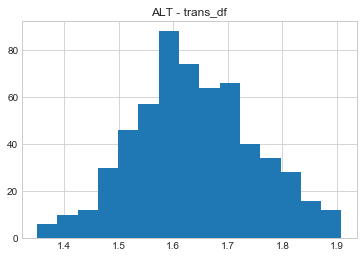

Skew:  0.07703671486028012


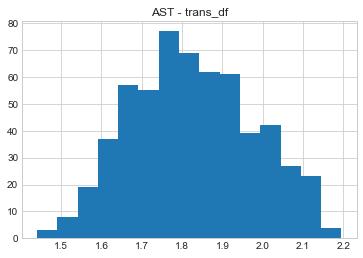

Skew:  0.10578146566817681


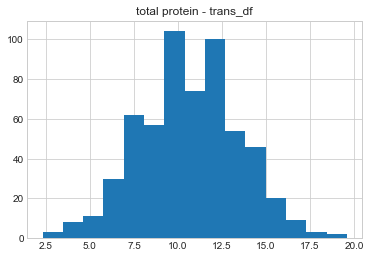

Skew:  -0.003159535900629572


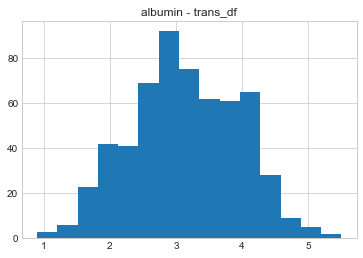

Skew:  -0.043572251735588034


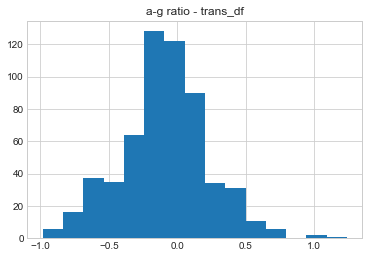

Skew:  0.020961981345698398


In [13]:
# apply best transformations to create unskewed dataset
trans_df = liver_df.copy()

trans_df['total bili'] = np.reciprocal(liver_df['total bili'])

box_cox_variables = ['direct bili', 'ALP', 'ALT', 'AST', 'total protein', 'a-g ratio']
bestlambdas = dict()

for variable in box_cox_variables:
    bc_transformed, bestlambdas[variable] = stats.boxcox(liver_df[variable])
    trans_df[variable] = bc_transformed

print('Box-Cox transform lambdas: \n', bestlambdas)

# visualize distributions of variables in transformed dataset
for variable in ('age', 'total bili', 'direct bili', 'ALP', 
                 'ALT', 'AST', 'total protein', 'albumin', 'a-g ratio'):
    array = np.array(trans_df[variable])
    plt.hist(array, bins=15)
    plt.title('{} - trans_df'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(array))

The data is now unskewed to the greatest degree possible. The next step is to scale all variables equally.

In [14]:
# scale dataset
scaled_df = trans_df.copy()
del scaled_df['sex']
del scaled_df['liver disease']

from sklearn.preprocessing import scale

columns = scaled_df.columns
scaled_df = pd.DataFrame(scale(scaled_df))
scaled_df.columns = columns

scaled_df.head()

,age,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio
0,1.252098,1.037466,-1.619068,-0.427510,-1.411104,-1.324482,0.255859,0.198969,-0.043054
1,1.066637,-1.505946,1.560237,1.771308,0.703902,0.859363,0.944262,0.073157,-0.600820
2,1.066637,-1.419867,1.447942,1.367003,0.635232,0.502276,0.449003,0.198969,-0.075928
3,0.819356,0.222078,0.001876,-0.498239,-1.705869,-1.137065,0.255859,0.324781,0.273327
4,1.684839,-1.192655,1.119668,-0.320870,-0.432562,0.354602,0.744057,-0.933340,-2.124993


Now that all the predictors are unskewed and equally scaled, PCA can be applied to derive the principal components of the dataset.

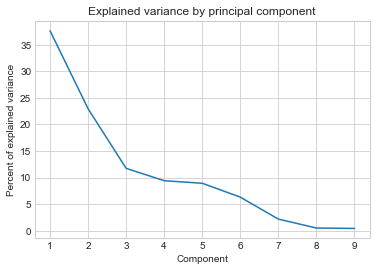

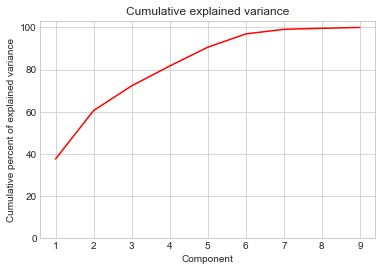

,Explained,Cumulative
Component,,
1,37.629533,37.629533
2,22.945416,60.574950
3,11.725070,72.300020
4,9.396178,81.696198
5,8.916580,90.612778
6,6.309926,96.922704
7,2.172293,99.094997
8,0.489785,99.584782
9,0.415218,100.000000


In [15]:
# perform PCA on scaled dataset
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_df)

pca_results = pd.DataFrame(pca.explained_variance_ratio_)
pca_results.columns = ['Explained']
pca_results['Cumulative'] = np.cumsum(pca.explained_variance_ratio_)
pca_results = pca_results*100
pca_results.index = range(1, 10)
pca_results.index.name = 'Component'

plt.plot(pca_results['Explained'])
plt.title('Explained variance by principal component')
plt.ylabel('Percent of explained variance')
plt.xlabel('Component')
plt.show()

plt.plot(pca_results['Cumulative'], color='red')
plt.title('Cumulative explained variance')
plt.ylabel('Cumulative percent of explained variance')
plt.xlabel('Component')
plt.ylim(ymin=0)
plt.show()

pca_results

The results of PCA show that the first 6 components explain almost 97% of the variance, and the first 7 explain more than 99% of the variance. Since we started with 9 variables, these results show that there is 2-3 variables' worth of redundancy in the data due to covariance. 

Transforming the data with these eigenvectors could therefore improve the performance of predictive modeling by reducing the dimensionality of the dataset, and producing uncorrelated features.

In [56]:
# generate eigenvector-transformed dataset
eigenvectors = pca.components_[0:4, :] #select first 7 components

new_df = np.dot(eigenvectors, scaled_df.transpose())
new_df = pd.DataFrame(new_df.transpose())
new_df.columns = ['Comp_{}'.format(x) for x in range(1, len(eigenvectors)+1)]

# bring in sex and liver disease info
new_df = pd.merge(new_df, trans_df[['sex', 'liver disease']], how='left', left_index=True, right_index=True)

new_df.head()

,Comp_1,Comp_2,Comp_3,Comp_4,sex,liver disease
0,-2.281071,1.421408,-0.908299,-0.551896,0,1
1,2.612689,-1.152219,-1.526395,-0.792950,1,1
2,2.117853,-0.969319,-1.350627,-0.215468,1,1
3,-1.429777,0.766481,-1.565760,0.339741,1,1
4,1.937330,1.097367,-2.045351,0.010235,1,1


In [57]:
# create train and test datasets
from sklearn.model_selection import train_test_split

X = new_df.copy()
y = X.pop('liver disease')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [58]:
# tune hyperparameters with cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'penalty': ['l1', 'l2'],
              'C': np.logspace(-5, 2, 100)}

logit = LogisticRegression()
logit_grid = GridSearchCV(logit, param_grid, cv=5, return_train_score=False)
logit_grid.fit(X_train, y_train)

print(logit_grid.best_params_)
print(logit_grid.best_score_)
cv_results = pd.DataFrame(logit_grid.cv_results_)
l1_results = cv_results[cv_results.param_penalty == 'l1']
l2_results = cv_results[cv_results.param_penalty == 'l2']

{'C': 0.006734150657750821, 'penalty': 'l2'}
0.7208237986270023


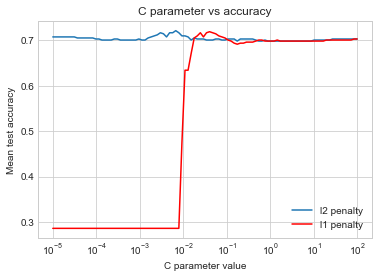

In [59]:
plt.plot(l2_results.param_C, l2_results.mean_test_score, label='l2 penalty')
plt.plot(l1_results.param_C, l1_results.mean_test_score, color='red', label='l1 penalty')
plt.xscale('log')
plt.title('C parameter vs accuracy')
plt.xlabel('C parameter value')
plt.ylabel('Mean test accuracy')
plt.legend(loc='lower right')
plt.show()

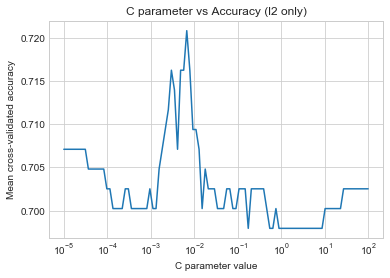

In [60]:
plt.plot(l2_results.param_C, l2_results.mean_test_score, label='l2 penalty')
plt.xscale('log')
plt.title('C parameter vs Accuracy (l2 only)')
plt.xlabel('C parameter value')
plt.ylabel('Mean cross-validated accuracy')
plt.show()

In [61]:
# baseline options ('l2' penalty and C=1) perform

model = LogisticRegression(C=10, penalty='l2')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7123287671232876

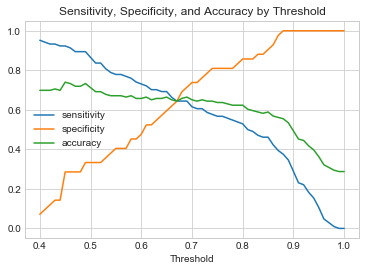

,sensitivity,specificity,accuracy
threshold,,,
0.40,0.951923,0.071429,0.698630
0.41,0.942308,0.095238,0.698630
0.42,0.932692,0.119048,0.698630
0.43,0.932692,0.142857,0.705479
0.44,0.923077,0.142857,0.698630
0.45,0.923077,0.285714,0.739726
0.46,0.913462,0.285714,0.732877
0.47,0.894231,0.285714,0.719178
0.48,0.894231,0.285714,0.719178


In [62]:
# plot model success metrics by threshold
from sklearn.metrics import confusion_matrix

def threshold_func_gen(threshold):
    ''' creates a thresholding function to convert probabilities to class designation '''
    def threshold_func(value):
        if value >= threshold:
            return 1
        else:
            return 0
    
    return threshold_func

predicted_probs = pd.Series(model.predict_proba(X_test)[:,1])
threshold_options = list(np.linspace(0.4, 1, num=61))
sens_by_thresh = np.empty(len(threshold_options))
spec_by_thresh = np.empty(len(threshold_options))
acc_by_thresh = np.empty(len(threshold_options))

for i, threshold in enumerate(threshold_options):
    threshold_func = threshold_func_gen(threshold)
    y_pred = predicted_probs.map(threshold_func)
    matrix = confusion_matrix(y_test, y_pred)
    sens_by_thresh[i] = matrix[1, 1]/np.sum(matrix[1,:])
    spec_by_thresh[i] = matrix[0, 0]/np.sum(matrix[0,:])
    acc_by_thresh[i] = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    
threshold_df = pd.DataFrame(threshold_options)
threshold_df['sensitivity'] = sens_by_thresh
threshold_df['specificity'] = spec_by_thresh
threshold_df['accuracy'] = acc_by_thresh
threshold_df.set_index(0, inplace=True)
threshold_df.index.name = 'threshold'
threshold_df.plot()
plt.title('Sensitivity, Specificity, and Accuracy by Threshold')
plt.xlabel('Threshold')
plt.show()
threshold_df

In [63]:
# try random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features=None)
params = {'n_estimators': range(100, 1001, 200), 
          'max_depth': [30, 50, 70, 90], 
          'min_samples_leaf': [2, 3, 4, 5]}
grid_rf = GridSearchCV(rf, params, cv=5, scoring='accuracy', n_jobs=7)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.7391304347826086
{'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 900}


In [64]:
model = grid_rf.best_estimator_
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.678082191780822

In [65]:
# try decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_features=None)
params = {'max_depth': range(10, 101, 10), 
          'min_samples_leaf': range(2, 10, 1)}
grid_tree = GridSearchCV(tree, params, cv=5, scoring='accuracy', n_jobs=7)
grid_tree.fit(X_train, y_train)
print(grid_tree.best_score_)
print(grid_tree.best_params_)

0.6979405034324943
{'max_depth': 10, 'min_samples_leaf': 9}


In [66]:
# try svm
from sklearn.svm import SVC

svm = SVC()
params = {'C': np.logspace(-2, 2, 20), 
          'gamma': np.logspace(-2, 2, 20)}
grid_svm = GridSearchCV(svm, params, cv=5, scoring='accuracy', n_jobs=7)
grid_svm.fit(X_train, y_train)
print(grid_svm.best_score_)
print(grid_svm.best_params_)

0.7459954233409611
{'C': 100.0, 'gamma': 0.04281332398719394}


In [67]:
model = grid_svm.best_estimator_
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7123287671232876

In [68]:
# try Gaussian process
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import cross_val_score

gauss = GaussianProcessClassifier()
score = cross_val_score(gauss, X_train, y_train, cv=5, scoring='accuracy', n_jobs=7)
print(score.mean())

0.7323406478578892


In [69]:
# try voting between RF, SVM, GaussianProcess

from sklearn.ensemble import VotingClassifier

models = [('rf', grid_rf.best_estimator_),
          ('svm', grid_svm.best_estimator_),
          ('gauss', GaussianProcessClassifier())]
voter = VotingClassifier(estimators=models, voting='hard')
score = cross_val_score(voter, X_train, y_train, cv=5, scoring='accuracy', n_jobs=7)
print(score.mean())

0.7483542319749216


In [70]:
voter.fit(X_train, y_train)
voter.score(X_test, y_test)

C:\Users\Nils\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6986301369863014